Saving credit_data.csv to credit_data.csv
            LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.2

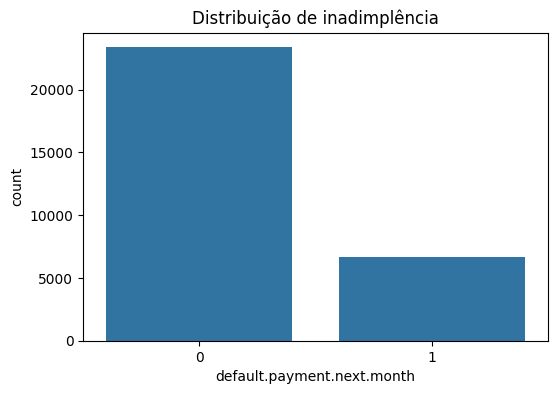

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:33:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


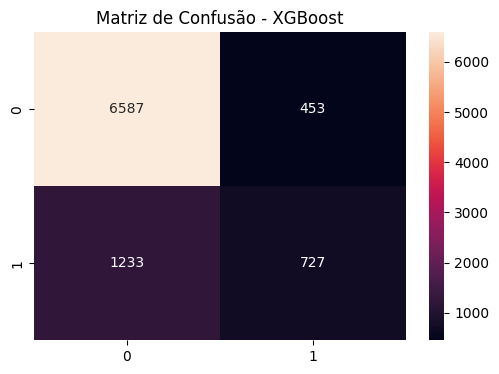

<Figure size 600x400 with 0 Axes>

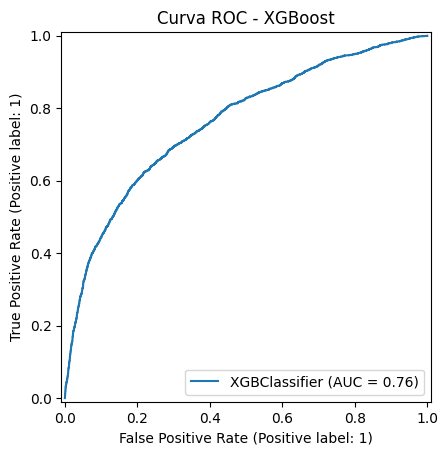


Comparação dos Modelos:

                Modelo  Acurácia  Precisão    Recall  F1-Score   AUC-ROC
0  Regressão Logística  0.808778  0.678625  0.231633  0.345378  0.600546
1        Random Forest  0.815333  0.630473  0.367347  0.464217  0.653702
2              XGBoost  0.812667  0.616102  0.370918  0.463057  0.653286


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Instalar bibliotecas necessárias
!pip install seaborn xgboost joblib

# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)
from xgboost import XGBClassifier
import joblib
from google.colab import files

%matplotlib inline

# Upload do CSV
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['credit_data.csv']))

# Limpeza e tratamento
if 'ID' in df.columns:
    df.drop('ID', axis=1, inplace=True)

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# EDA básico (opcional)
print(df.describe())
plt.figure(figsize=(6,4))
sns.countplot(x='default.payment.next.month', data=df)
plt.title('Distribuição de inadimplência')
plt.show()

# Preparação dos dados
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===== Modelo 1: Regressão Logística =====
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# Métricas Regressão Logística
metrics_log = {
    'Modelo': 'Regressão Logística',
    'Acurácia': accuracy_score(y_test, y_pred_log),
    'Precisão': precision_score(y_test, y_pred_log),
    'Recall': recall_score(y_test, y_pred_log),
    'F1-Score': f1_score(y_test, y_pred_log),
    'AUC-ROC': roc_auc_score(y_test, y_pred_log)
}

# ===== Modelo 2: Random Forest com GridSearch =====
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

metrics_rf = {
    'Modelo': 'Random Forest',
    'Acurácia': accuracy_score(y_test, y_pred_rf),
    'Precisão': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'AUC-ROC': roc_auc_score(y_test, y_pred_rf)
}

# ===== Modelo 3: XGBoost =====
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

metrics_xgb = {
    'Modelo': 'XGBoost',
    'Acurácia': accuracy_score(y_test, y_pred_xgb),
    'Precisão': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'AUC-ROC': roc_auc_score(y_test, y_pred_xgb)
}

# Mostrar matriz de confusão e curva ROC do melhor modelo (XGBoost aqui como exemplo)
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d')
plt.title('Matriz de Confusão - XGBoost')
plt.show()

plt.figure(figsize=(6,4))
RocCurveDisplay.from_estimator(xgb, X_test_scaled, y_test)
plt.title('Curva ROC - XGBoost')
plt.show()

# Comparar métricas em tabela
df_metricas = pd.DataFrame([metrics_log, metrics_rf, metrics_xgb])
print("\nComparação dos Modelos:\n")
print(df_metricas)

# Salvar melhor modelo (XGBoost neste exemplo)
joblib.dump(xgb, 'melhor_modelo.pkl')
files.download('melhor_modelo.pkl')
